# Optmizacion del modelo

In [1]:
# importamos las librerías a utilizar
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve,roc_curve,confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier, plot_importance

# Configuracion de las rutas para lograr las importaciones

In [2]:
import sys
import os

# obtiene la ruta absoluta del directorio 'src' desde la ubicación del notebook
src_path = os.path.abspath(os.path.join('..', 'src'))

# agrega la ruta a 'src' al sys.path si no está ya presente
if src_path not in sys.path:
    sys.path.append(src_path)

# Cargamos los datos pre-procesados

In [3]:
from src.constants import X_TRAIN_PATH, X_TEST_PATH, Y_TRAIN_PATH, Y_TEST_PATH

# save the processed data to their corresponding files
X_train = pd.read_csv(filepath_or_buffer=X_TRAIN_PATH, sep=',')
X_test = pd.read_csv(filepath_or_buffer=X_TEST_PATH, sep=',')

y_train = pd.read_csv(filepath_or_buffer=Y_TRAIN_PATH, sep=',')
y_train = y_train['is_canceled'].to_numpy()

y_test = pd.read_csv(filepath_or_buffer=Y_TEST_PATH, sep=',')
y_test = y_test['is_canceled'].to_numpy()

In [4]:
# Mostramos información básica
X_train.describe()

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,...,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
count,95512.000000,95512.000000,95512.000000,95512.000000,95512.000000,95512.000000,95512.000000,95508.000000,95512.000000,95512.000000,...,95512.000000,95512.000000,95512.000000,95512.000000,95512.000000,95512.000000,95512.000000,95512.000000,95512.000000,95512.000000
mean,103.879931,2016.156483,27.127994,15.799575,0.927444,2.498953,1.856008,0.103279,0.007737,0.085173,...,0.002324,0.000010,0.000115,0.875932,0.122676,0.001392,0.033954,0.004628,0.749749,0.211670
std,106.870094,0.706882,13.610117,8.792557,0.998429,1.910708,0.584467,0.397270,0.098106,0.818956,...,0.048155,0.003236,0.010731,0.329661,0.328066,0.037290,0.181111,0.067870,0.433160,0.408494
min,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,69.000000,2016.000000,27.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,26.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Construccion del modelo XGBoost optimizado

## Inicializamos el modelo

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score, roc_auc_score


# Inicializamos el modelo
model = XGBClassifier(eval_metric='logloss', random_state=42)

## Definimos la estrategia de validacion

In [6]:
# definir la estrategia de validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Definimos las metricas e evaluacion

In [7]:
# definir las métricas de evaluación
scoring = {
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

## Creamos la malla de hiperparametros

In [8]:
from sklearn.model_selection import GridSearchCV

# definimos la malla de hiperparametros
param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1],
    'scale_pos_weight': [1, 3, 5, 7]
}

## Configuramos la búsqueda aleatoria con los parametros construidos

In [9]:
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=50,  # Ajusta el número de iteraciones según tu tiempo
    scoring=scoring,
    cv=cv,
    refit='f1',  # Métrica para seleccionar el mejor modelo
    random_state=42,
    #n_jobs=-1, Utilizar todos los núcleos disponibles
    verbose=2
)

# Hacemos fit del modelo

In [10]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=9, n_estimators=100, reg_alpha=0.1, reg_lambda=0.5, scale_pos_weight=3, subsample=0.9; total time=   1.9s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=9, n_estimators=100, reg_alpha=0.1, reg_lambda=0.5, scale_pos_weight=3, subsample=0.9; total time=   1.6s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=9, n_estimators=100, reg_alpha=0.1, reg_lambda=0.5, scale_pos_weight=3, subsample=0.9; total time=   1.5s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=9, n_estimators=100, reg_alpha=0.1, reg_lambda=0.5, scale_pos_weight=3, subsample=0.9; total time=   1.6s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=9, n_estimators=100, reg_alpha=0.1, reg_lambda=0.5, scale_pos_weight=3, subsample=0.9; total time=   1.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_ra

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           imp...
                                        'learning_rate': [0.01, 0.03, 0.05, 0.1,
                                                          0.2],
                                        'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [100, 300, 500, 700],
                                        'reg_alpha': [0, 0.1, 0.5, 1],
                                        'reg_lambda': [0, 0.1, 0.5, 1],
                                        'scale_pos_weight': [1, 3, 5, 7],
                                        'subsample': [0.7, 0.8, 0.9, 1.0]},
                   random_state=42, refit='f1',
                   scoring={'f1': make_scorer(f1_score, response_method='predict'),
                            'roc_auc': make_scorer(roc_auc_score, response_method='predict')},
                   verbose=2)

# Evaluación del modelo

In [11]:
# Para ver los mejores resultados:
print("Mejores hiperparámetros:", random_search.best_params_)
print("Mejor puntaje F1:", random_search.best_score_)

best_model = random_search.best_estimator_

Mejores hiperparámetros: {'subsample': 0.8, 'scale_pos_weight': 5, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.7}
Mejor puntaje F1: 0.8396485856977751


In [12]:
# Predicciones y evaluación
y_pred = best_model.predict(X_test)

In [13]:
y_proba = best_model.predict_proba(X_test)[:, 1]

## Matriz de confusion


Matriz de confusion:


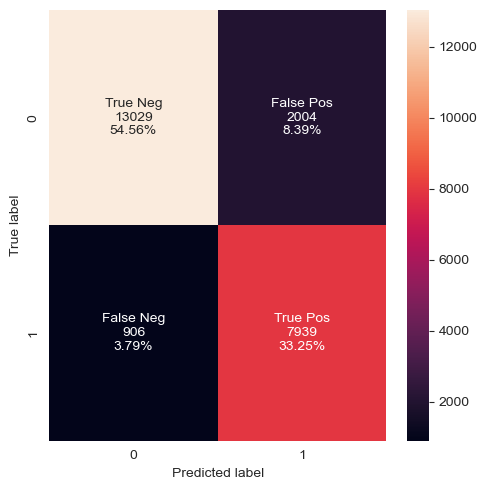

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
from draw_utils import draw_confusion_matrix


# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nMatriz de confusion:")
draw_confusion_matrix(conf_matrix)


Interpretación rápida:

- True Neg  **(13713)** → Reservas no canceladas predichas correctamente.
- True Pos  **(7237)** → Cancelaciones correctamente detectadas.
- False Pos **(1194)** → Predijo cancelación, pero la reserva no fue cancelada.
- False Neg **(1734)** → No predijo cancelación, pero sí se canceló.

Con base en estos números, el modelo está haciendo un trabajo razonable, pero hay margen de mejora en los falsos negativos si nuestro objetivo es minimizar el **churn** (posibilidad de que alguien siga con el servicio).

## Metrica ROC AUC

Hacemos el estudio de la metrica ROC AUC para verificar el desempeno del modelo. Se sekecciona esta metrica para el estudio debido a que la data se encuentra desbalanceada.

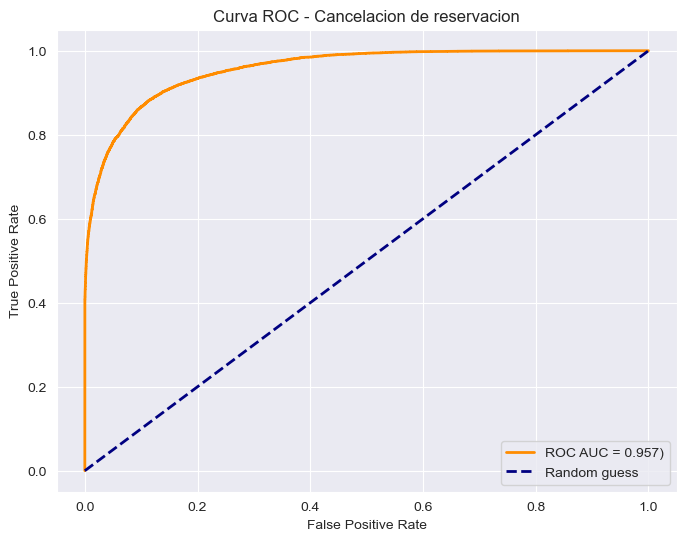

In [15]:
from draw_utils import draw_roc_auc


draw_roc_auc(
    y_test=y_test,
    y_prob=y_proba,
    g_title='Curva ROC - Cancelacion de reservacion'
)

## Seleccion del mejor threshold

Para este valor de Auc Roc estudiamos los puntos de corte donde mejor F1-score obtengamos

In [16]:
# F1 Score por cuantiles
df_eval = pd.DataFrame({'true': y_test, 'proba': y_proba})
# construimos los thresholds a estudiar
thresholds = np.quantile(df_eval['proba'], np.linspace(0.1, 0.9))
scores = []

for t in thresholds:
    # realizamos la prediccion de forma manual con base en
    # las probabilidades que se obtienen del modelo
    pred = (df_eval['proba'] >= t).astype(int)

    #calculamos el f1-score
    f1 = f1_score(df_eval['true'], pred)

    # guardamos el score
    scores.append((t, f1))

print("\n📊 --- F1 Score por punto de corte (cuantiles) ---")
for t, f1 in scores:
    print(f"Threshold: {t:.2f} | F1 Score: {f1:.3f}")


📊 --- F1 Score por punto de corte (cuantiles) ---
Threshold: 0.00 | F1 Score: 0.583
Threshold: 0.00 | F1 Score: 0.590
Threshold: 0.00 | F1 Score: 0.598
Threshold: 0.00 | F1 Score: 0.606
Threshold: 0.00 | F1 Score: 0.614
Threshold: 0.00 | F1 Score: 0.623
Threshold: 0.00 | F1 Score: 0.631
Threshold: 0.00 | F1 Score: 0.640
Threshold: 0.00 | F1 Score: 0.649
Threshold: 0.00 | F1 Score: 0.658
Threshold: 0.00 | F1 Score: 0.667
Threshold: 0.00 | F1 Score: 0.677
Threshold: 0.01 | F1 Score: 0.686
Threshold: 0.01 | F1 Score: 0.696
Threshold: 0.01 | F1 Score: 0.706
Threshold: 0.02 | F1 Score: 0.716
Threshold: 0.02 | F1 Score: 0.726
Threshold: 0.03 | F1 Score: 0.736
Threshold: 0.04 | F1 Score: 0.746
Threshold: 0.06 | F1 Score: 0.755
Threshold: 0.08 | F1 Score: 0.765
Threshold: 0.10 | F1 Score: 0.775
Threshold: 0.13 | F1 Score: 0.783
Threshold: 0.16 | F1 Score: 0.792
Threshold: 0.19 | F1 Score: 0.802
Threshold: 0.23 | F1 Score: 0.811
Threshold: 0.28 | F1 Score: 0.820
Threshold: 0.33 | F1 Score: 0.8

In [17]:
# seleccionamos el mejor threshold
best_threshold = max(scores, key=lambda x: x[1])[0]

# realizamos las predicciones con este nuevo threshold de clasificacion
y_pred_best_threshold = (y_proba >= best_threshold).astype(int)

print(f"\n✅ Mejor threshold (F1): {best_threshold:.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_best_threshold):.3f}")
print(f"AUC (el mismo valor visto en la grafica anterior): {roc_auc_score(y_test, y_proba):.3f}")


✅ Mejor threshold (F1): 0.65
F1 Score: 0.851
AUC (el mismo valor visto en la grafica anterior): 0.957



Matriz de confusion:


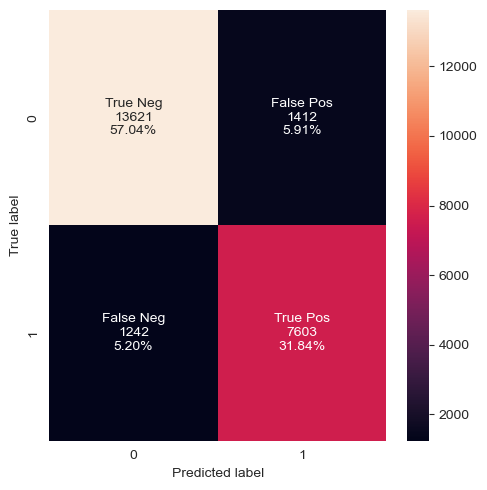

In [18]:
# matriz de confusión con el nuevo threshold
conf_matrix_with_opt_f1_score = confusion_matrix(y_test, y_pred_best_threshold)

print("\nMatriz de confusion:")

draw_confusion_matrix(conf_matrix_with_opt_f1_score)

Comparamos ambas matrices de confusion, la original y con el nuevo threshold

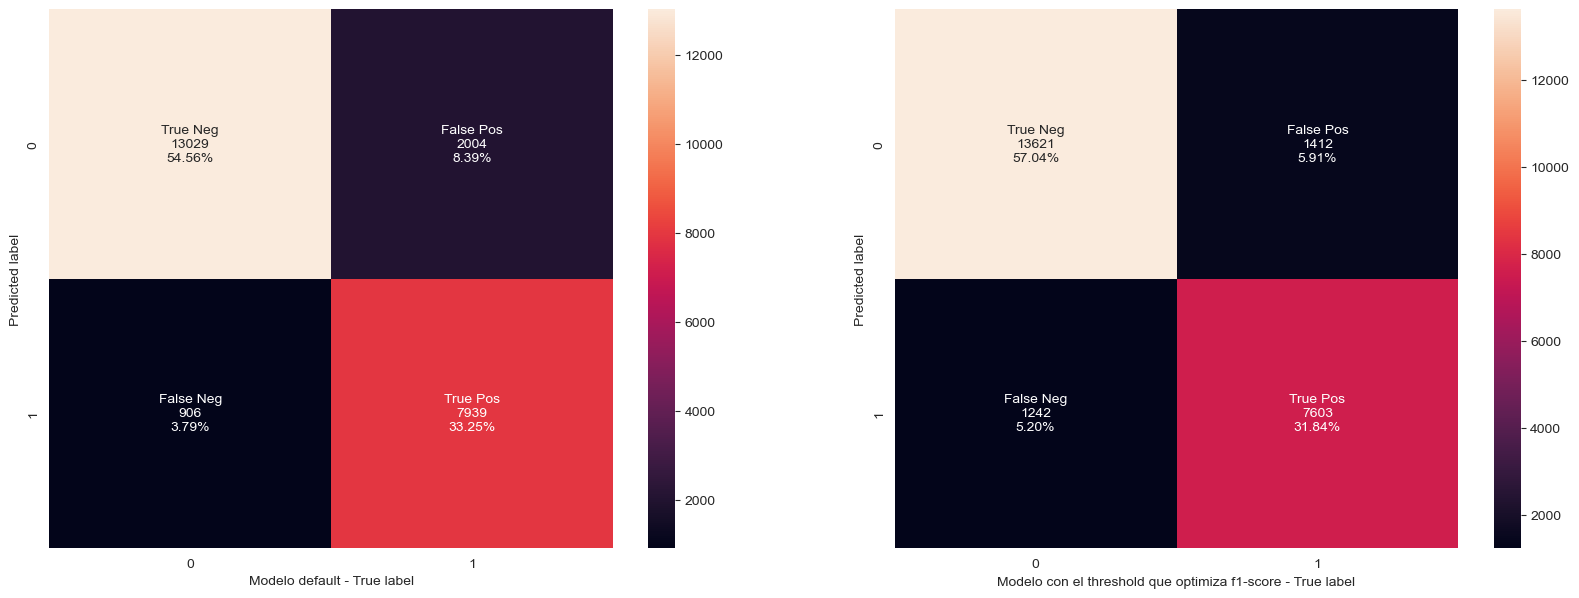

<Figure size 1000x500 with 0 Axes>

In [19]:
from src.draw_utils import draw_comparison_confusion_matrices

draw_comparison_confusion_matrices(
    confusion_1=conf_matrix,
    confusion_2=conf_matrix_with_opt_f1_score,
    confusion_matrix_1_name='Modelo default',
    confusion_matrix_2_name='Modelo con el threshold que optimiza f1-score'
)

Podemos obsevar que con el nuevo threshold el modelo posee un peor performace con la clase que posee menor cantidad de datos.

## Grafico precision - recall

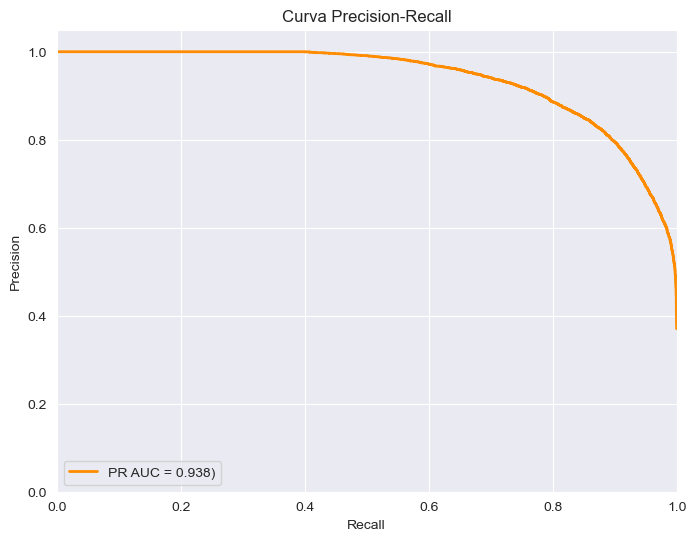

In [20]:
from draw_utils import draw_pr_auc


draw_pr_auc(
    y_test=y_test,
    y_prob=y_proba,
    g_title='Curva ROC - Cancelacion de reservacion'
)

Podemos observar que nuestro modelo a tratar de mejorar el Recall disminuye la precision. Por lo tanto, al tratar de mejorar la capacidad del modelo de identificar las personas que cancelaran la capacida de identificar las personas que no cancelan disminuira.

## Interpretacion SHAP

100%|===================| 23874/23878 [13:46<00:00]        

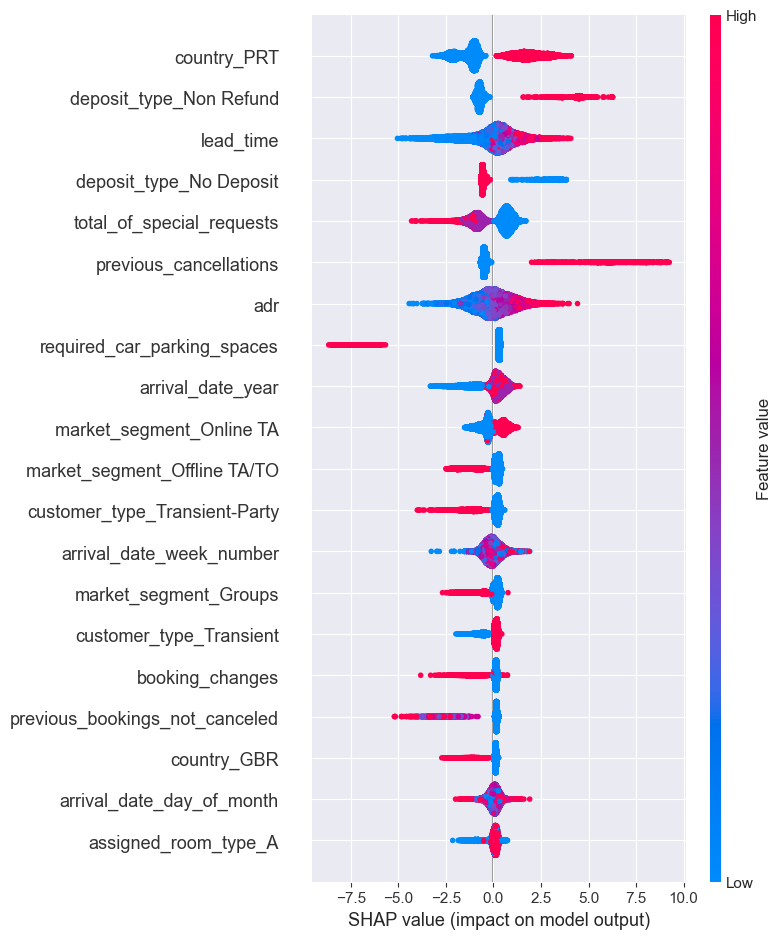

In [21]:
import shap

# interpretación SHAP
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

La variable con mas importancia que podemos ver en este gráfico (deposit_type), es la que tiene mas impacto en el modelo, es decir que los depositos que no se realizaron generan mas probabilidad de cancelación

In [22]:
# Métricas de clasificación
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90     15033
           1       0.80      0.90      0.85      8845

    accuracy                           0.88     23878
   macro avg       0.87      0.88      0.87     23878
weighted avg       0.88      0.88      0.88     23878



Podemos observar que el modelo posee buenas métricas con valores de precision, recall y f1-score cercanos por lo tanto parece no existir un alto overfitting.

## Estudio de la importancia de cada variable

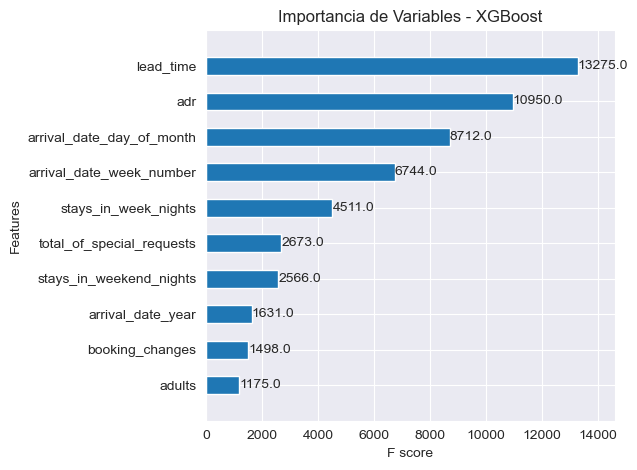

In [23]:
#Interpretación del modelo – Importancia de Variables
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Visualización de importancia de las características
plot_importance(best_model, max_num_features=10, height=0.5)
plt.title("Importancia de Variables - XGBoost")
plt.tight_layout()
plt.show()

## Interpretación de Importancia de Variables

Las top 3 variables que más influyen en la predicción de cancelaciones son:

1. lead_time (Tiempo entre reserva y llegada) → cuanto mayor, más riesgo de cancelación.
2. adr	(Precio medio por noche) → precios altos pueden ser más susceptibles a cancelación.
3. country	(Origen del huésped) → posiblemente refleja patrones culturales o restricciones.

In [24]:
# Crear DataFrame con importancias
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
})

# Ordenar por importancia descendente
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Mostrar tabla
feature_importances.reset_index(drop=True, inplace=True)
feature_importances.head(15)


,Feature,Importance
0,deposit_type_Non Refund,0.598991
1,required_car_parking_spaces,0.114964
2,deposit_type_No Deposit,0.017803
3,previous_cancellations,0.015117
4,market_segment_Online TA,0.010886
5,country_PRT,0.009642
6,assigned_room_type_P,0.009022
7,reserved_room_type_P,0.007973
8,assigned_room_type_I,0.006699
9,country_AGO,0.005191


# Salvamos el modelo optimizado

In [25]:
from pickle import dump

model_file_name = '../models/opt_model.pkl'

with open(model_file_name, "wb") as f:
    dump(best_model, f, protocol=5)